# NLP: Ngram and Sentiment Analysis

_____

### Part I - Analyzing Sentiment using Tweeter Feeds
    Company in Review: Netflix
    Period: 1-10th April'23
    Tweets Limit: 1000


In [6]:
#Importing relevent Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import snscrape.modules.twitter as sntwitter
import spacy
from wordcloud import WordCloud
import nltk
from textblob import TextBlob
import datetime

#### Task 1: Tweet Collection

In [4]:
limit = 1000 # maximum number of tweets to retrieve

start_date = datetime.datetime(2022, 4, 1)
end_date = datetime.datetime(2022, 4, 10)
since_str = start_date.strftime('%Y-%m-%d')
until_str = end_date.strftime('%Y-%m-%d')


query = "Netflix lang:en since:{since} until:{until}" # Replace 'Netflix' with company name that you want to analyse
query = query.format(since=since_str, until=until_str)

In [5]:
tweets = []
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    if len(tweets) == limit:
        break 
    else:
        tweets.append([tweet.id, tweet.date, tweet.rawContent])
        
df_new = pd.DataFrame(tweets, columns=['Id','Date','Tweets'])
df_new.head()

,Id,Date,Tweets
0,1512943420653801472,2022-04-09 23:59:55+00:00,"Streaming in Canada on Amazon Prime Video, App..."
1,1512943409027235842,2022-04-09 23:59:52+00:00,@KenW9270 But…… I don’t have Disney+ 😂 only Ne...
2,1512943371840634886,2022-04-09 23:59:43+00:00,melhor original da netflix: stranger things!
3,1512943366312501250,2022-04-09 23:59:42+00:00,This show on Netflix called The Ultimatum is c...
4,1512943357194031107,2022-04-09 23:59:40+00:00,@Chicanatravels I just watched Heavenly bites ...


#### Task 2: N-gram Analysis

In [6]:
nlp = spacy.load("en_core_web_sm")

# Apply NLP to each tweet in the dataframe
docs = df_new['Tweets'].apply(nlp)

word_frequencies = {}

for doc in docs:
    for token in doc:
        # Only process words that are not stop words, punctuation, or whitespace
        if not token.is_stop and not token.is_punct and not token.is_space:
            # If the word is already in the word_frequencies dictionary, increase its count
            if token.text in word_frequencies:
                word_frequencies[token.text] += 1
            # Otherwise, add the word to the dictionary with a count of 1
            else:
                word_frequencies[token.text] = 1


In [7]:
#Filtering and Sorting

# Use the dictionary to craete a Pandas dataframe
df = pd.DataFrame(list(word_frequencies.items()), columns = ['Word', 'Frequency'])

#sort by frequency 
df = df.sort_values(by='Frequency', ascending=False)

# filter words with frequency more than equal to 25
df = df.query("Frequency >= 25")


df.head(10) # Top Word frequency based on its repetition

,Word,Frequency
8,Netflix,721
22,netflix,158
55,@netflix,135
133,watch,98
100,good,73
72,watching,67
79,amp,60
400,like,58
215,😭,54
87,series,47


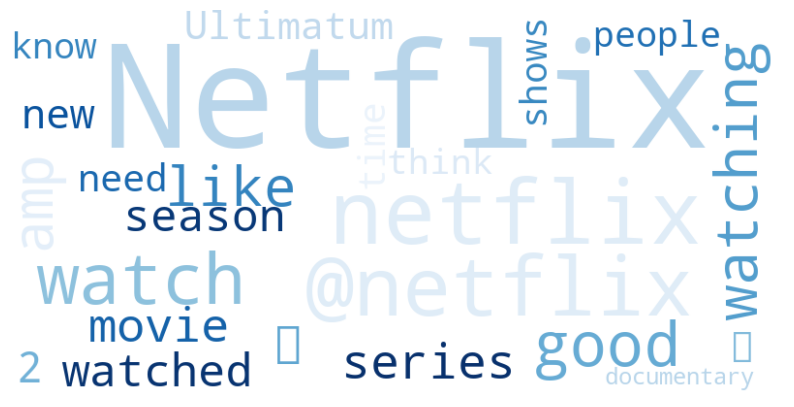

In [8]:
word_dict = dict(zip(df['Word'], df['Frequency']))

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues',
                      max_font_size=150, min_font_size=10).generate_from_frequencies(word_dict)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

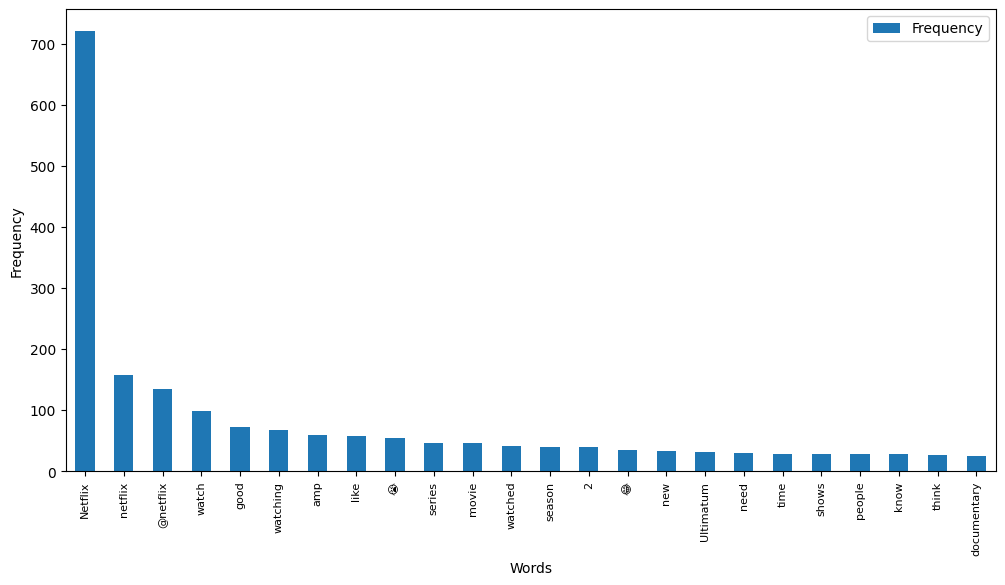

In [9]:

# Set the figure size
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
df.plot(kind='bar', x='Word', y='Frequency', ax=ax)

# Set the x-axis and y-axis labels
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')

# Set the font size of the x-axis labels
plt.xticks(fontsize=8)

# Show the plot
plt.show()


    Insights: Top frequent words are Netflix, Watch, Good, Amp,Like,Series, movies

#### Task 3: Sentiment Analysis

In [10]:
all_tweets = ' '.join(df_new['Tweets'].tolist())

In [11]:
# Tokenization

nltk.download('punkt')
sentences = nltk.sent_tokenize(all_tweets)

#### Polarity Score
    
    Polarity refers to the degree of positivity, negativity, or neutrality of a text. It is measured on a scale ranging from -1 to 1, where -1 indicates very negative sentiment, 0 indicates neutral sentiment, and 1 indicates very positive sentiment. For example, the polarity of a sentence like "I love this product" would be close to 1, while the polarity of a sentence like "I hate this product" would be close to -1.

In [12]:
polarity_scores = []

for sentence in sentences:
    blob = TextBlob(sentence)
    polarity = blob.sentiment.polarity
    polarity_scores.append(polarity)

print("Average polarity score:", np.mean(polarity_scores))

Average polarity score: 0.10831751507540717


    Polarity Score of .10 which is slightly positive, indicating that the sentiment towards Netflix is generally positive.

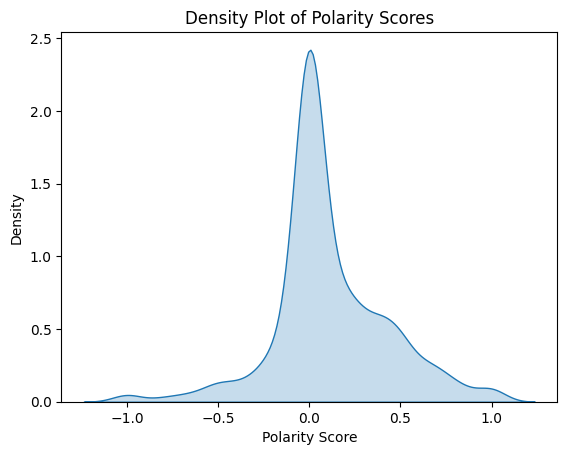

In [13]:
sns.kdeplot(polarity_scores, fill=True)
plt.xlabel('Polarity Score')
plt.ylabel('Density')
plt.title('Density Plot of Polarity Scores')
plt.show()

    Insight: Polarity Density Plots follows Normal Distribution,which means that most of the scores are concentrated around the mean (0.107) and the scores become less frequent as they move away from the mean in either direction. This implies that the sentiment of the tweets is relatively consistent and the majority of tweets have a similar polarity score, with a few outliers having significantly positive or negative scores.

___

#### Subjective Score
    Subjectivity refers to the degree of personal feelings, emotions, or opinions reflected in a text. It is measured on a scale ranging from 0 to 1, where 0 indicates that a text is very objective and based purely on facts, and 1 indicates that a text is very subjective and based purely on personal opinions. For example, a news article reporting on a political event might have a low subjectivity score, while a personal blog post expressing opinions about the same event might have a higher subjectivity score.

In [14]:
# Subjective Score
subjectivity_scores = []

for sentence in sentences:
    blob = TextBlob(sentence)
    subjectivity = blob.sentiment.subjectivity
    subjectivity_scores.append(subjectivity)

print("Average subjectivity score:", np.mean(subjectivity_scores))

Average subjectivity score: 0.38138859677915293


    Subjectivity Score of 0.3814 means that the text is somewhat subjective, indicating that it expresses personal opinions or feelings rather than factual information.

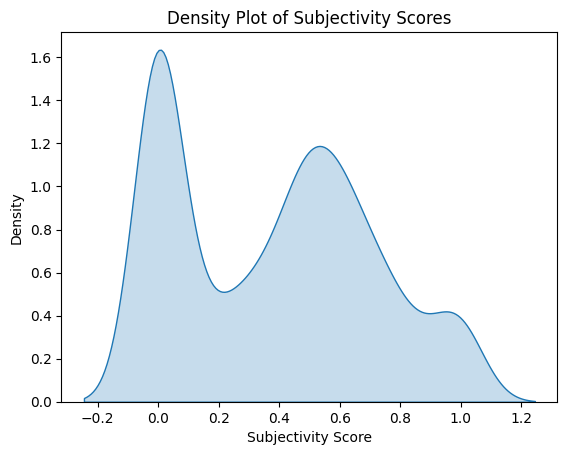

In [15]:
sns.kdeplot(subjectivity_scores, fill=True)
plt.xlabel('Subjectivity Score')
plt.ylabel('Density')
plt.title('Density Plot of Subjectivity Scores')
plt.show()

    The Density Plot suggests that the scores are skewed towards the lower end, with a large number of sentences having low subjectivity scores and fewer sentences with higher subjectivity scores. This means that the text may be more factual and less opinionated.

#### Task 4: Descriptive and Prescriptive Analysis

<b>Descriptive Analysis:</b>
       
       The sentiment analysis shows an average polarity score of 0.1079, which is slightly positive, indicating that the sentiment towards Netflix is generally positive. The average subjectivity score is 0.3814, indicating that the tweets are moderately subjective.
    
    Based on these insights, we can conclude that the sentiment towards Netflix is positive, and people seem to enjoy watching it. Therefore, from a descriptive analysis point of view, Netflix seems to be doing well.



<b>Prescriptive Analysis:</b>

    From a prescriptive analysis point of view, if one is considering buying Netflix's stock, it would be a good idea to look at other factors such as financial statements and trends in the stock market to make a more informed decision. 
    
    However, based on the sentiment analysis, it suggests that Netflix is well-liked and popular, which could be a good sign for the company's future prospects.

______________

______________